In [ ]:
%%writefile kaggle.json
{
  "username": "tarrafff",
  "key": "KGAT_1b9872ccef5f52bb7a5987e8529b5c61"
}

Overwriting kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d wordsforthewise/lending-club

Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
License(s): CC0-1.0
 99% 1.25G/1.26G [00:09<00:00, 189MB/s]
100% 1.26G/1.26G [00:09<00:00, 150MB/s]


In [ ]:
!unzip -o lending-club.zip

Archive:  lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


In [ ]:
import pandas as pd

chunks = pd.read_csv(
    "accepted_2007_to_2018Q4.csv.gz",
    compression='gzip',
    low_memory=False,
    chunksize=300000
)

df = pd.concat(chunks)
df.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.dropna(thresh=len(df) * 0.7, axis=1)


In [ ]:
df.isna().sum()

,0
id,0
loan_amnt,33
funded_amnt,33
funded_amnt_inv,33
term,33
...,...
total_bc_limit,50063
total_il_high_credit_limit,70309
hardship_flag,33
disbursement_method,33


In [ ]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,...,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N


In [ ]:
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].astype(str)
        df[col] = df[col].fillna(df[col].mode()[0])


In [ ]:
import numpy as np
import pandas as pd


def whisker(col):
    col_data = col.dropna()
    q1, q3 = np.percentile(col_data, [25, 75])
    iqr = q3 - q1
    lw = q1 - 1.5 * iqr
    uw = q3 + 1.5 * iqr
    return lw, uw


num_cols = df.select_dtypes(include=['int64', 'float64']).columns


for col_name in num_cols:


    lower_bound, upper_bound = whisker(df[col_name])
    df[col_name] = np.where(df[col_name] > upper_bound, upper_bound, df[col_name])
    df[col_name] = np.where(df[col_name] < lower_bound, lower_bound, df[col_name])




In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = scaler.fit_transform(df[num_cols])

print("Standardization done.")

Standardization done.


In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = df.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))


In [ ]:


X = df.drop('loan_status', axis=1)
y = df['loan_status']

correlation_with_target = df.corr()['loan_status'].abs().sort_values(ascending=False)
correlation_threshold = 0.05
selected_features_corr = correlation_with_target[correlation_with_target >= correlation_threshold].index.tolist()

if 'loan_status' in selected_features_corr:
    selected_features_corr.remove('loan_status')

df_selected_corr = df[selected_features_corr + ['loan_status']]

print(" Selected Features (Correlation Filter):")
for i, feature in enumerate(selected_features_corr, 1):
    print(f"{i}. {feature}")

print(f"Final DataFrame shape (Correlation Filter): {df_selected_corr.shape}")

 Selected Features (Correlation Filter):
1. last_pymnt_amnt
2. total_rec_prncp
3. out_prncp_inv
4. out_prncp
5. total_pymnt
6. total_pymnt_inv
7. last_fico_range_low
8. last_fico_range_high
9. last_pymnt_d
10. id
11. url
12. initial_list_status
13. term
14. last_credit_pull_d
15. debt_settlement_flag
16. disbursement_method
17. application_type
18. int_rate
19. dti
20. funded_amnt_inv
21. funded_amnt
22. loan_amnt
23. mort_acc
24. sub_grade
25. grade
26. num_bc_tl
27. total_acc
28. num_rev_accts
Final DataFrame shape (Correlation Filter): (2260701, 29)


# **Supervised Learning: Decision Tree**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree


Take a copy of the data and split it into a training set and a testing set, with 70% for training and 30% for testing.

In [ ]:
df_copy= df_selected_corr.copy()

X = df_copy.drop('loan_status', axis=1)
y = df_copy['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

Preparing the decision tree model. We set max_depth=5 to prevent the model from overfitting and to make the tree readable.

In [ ]:

dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=50,
    random_state=42
)

#Training Model
dt_model.fit(X_train, y_train)

# Testing
y_pred = dt_model.predict(X_test)

Calculate and print overall accuracy

In [ ]:

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy based on selected features: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy based on selected features: 0.9610

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     80568
           1       0.98      0.99      0.99    263495
           2       0.00      0.00      0.00        12
           3       0.40      0.04      0.06       228
           4       0.00      0.00      0.00       596
           5       0.97      0.97      0.97    323026
           6       0.00      0.00      0.00      2531
           7       0.00      0.00      0.00      1305
           8       0.99      0.78      0.87      6440
           9       1.00      1.00      1.00        10

    accuracy                           0.96    678211
   macro avg       0.52      0.47      0.48    678211
weighted avg       0.95      0.96      0.96    678211



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ranking features by importance

/tmp/ipython-input-1554190293.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')


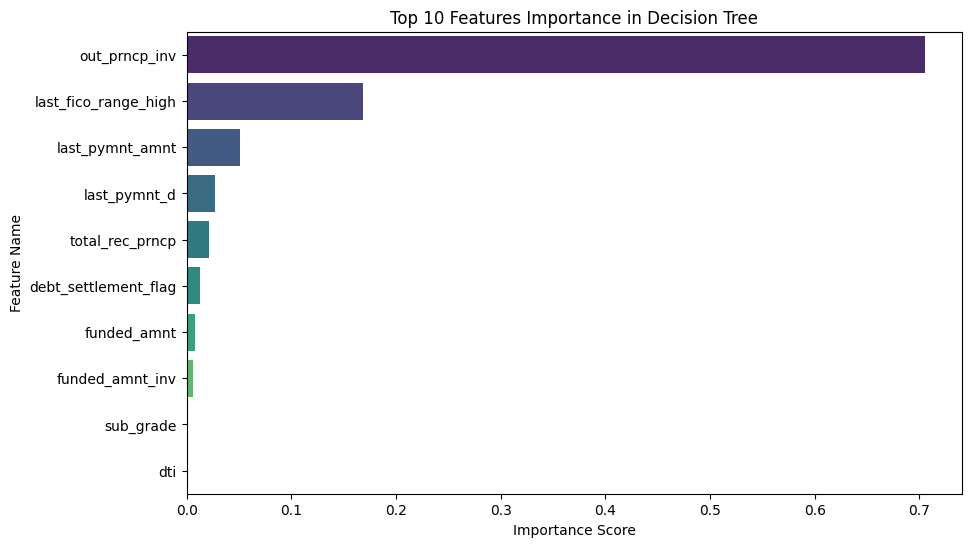

In [ ]:

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Features Importance in Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

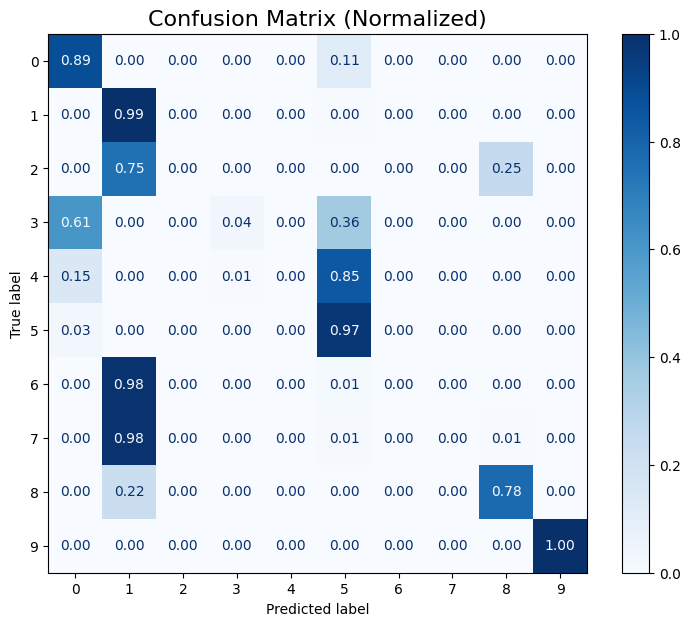

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))


disp = ConfusionMatrixDisplay.from_predictions (
    y_test,
    y_pred,
    normalize='true',
    cmap='Blues',
    values_format='.2f',
    ax=ax )

plt.title("Confusion Matrix (Normalized)", fontsize=16)
plt.show()

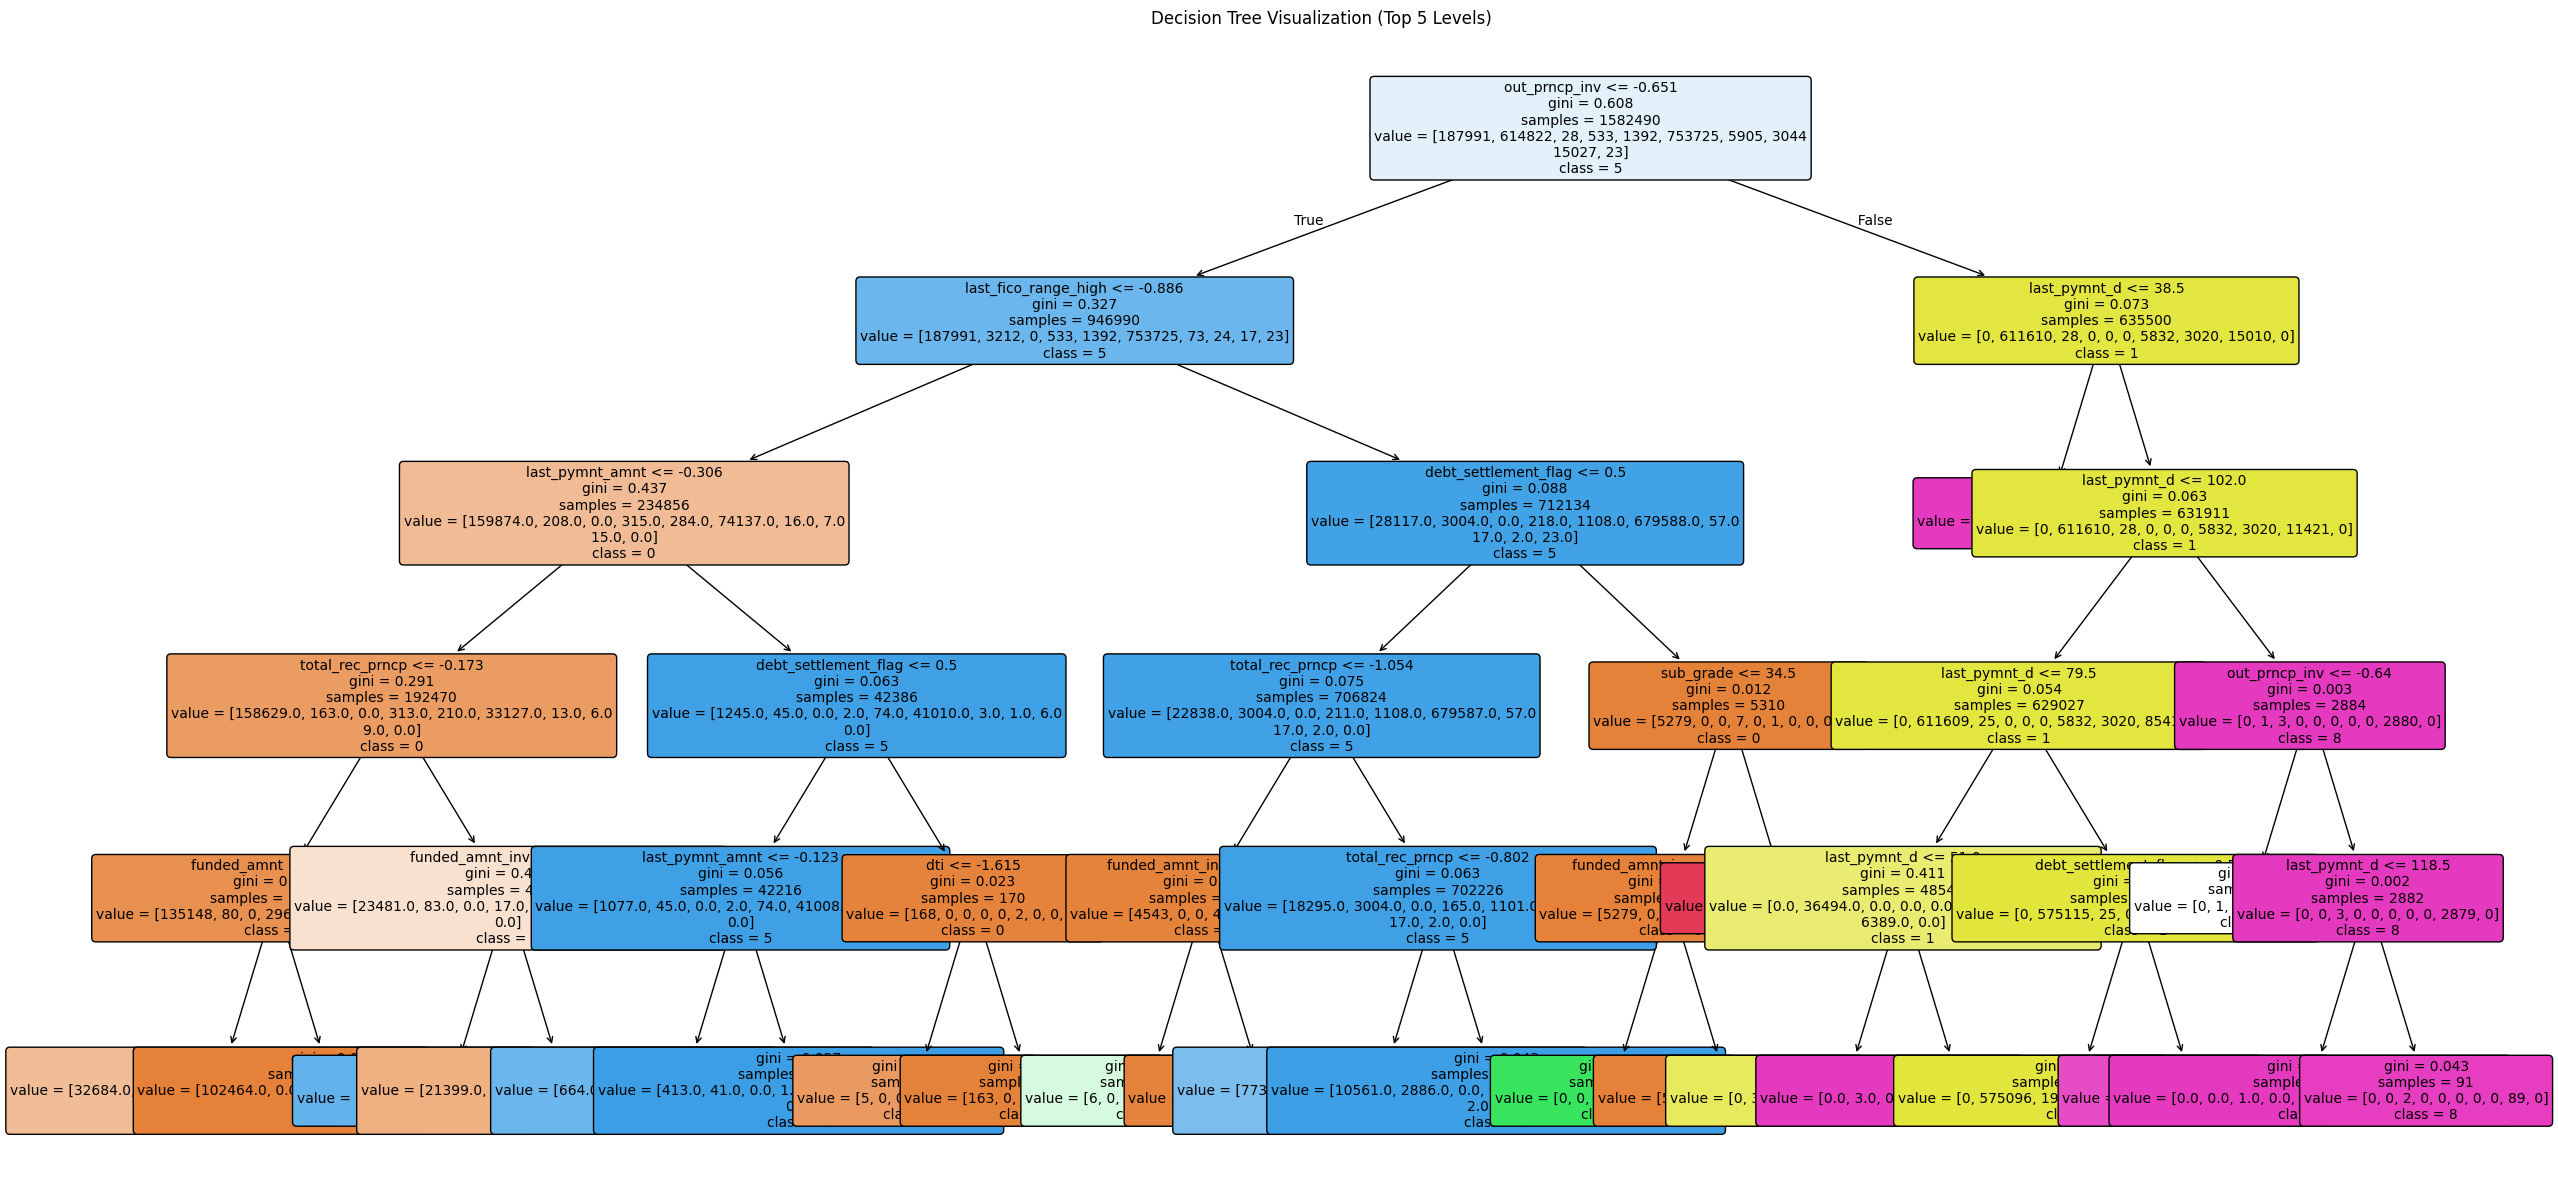

In [ ]:

plt.figure(figsize=(30, 15))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=[str(c) for c in dt_model.classes_],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree Visualization (Top 5 Levels)')
plt.show()

# **Summary of Decision Tree**

In [ ]:

train_acc = dt_model.score(X_train, y_train)
test_acc = accuracy_score(y_test, y_pred)
top_feats = pd.Series(dt_model.feature_importances_, index=X.columns).nlargest(3)
total_errors = sum(y_test != y_pred)
error_rate = total_errors / len(y_test)


print(f"DT Summary\n")
print(f"1. Accuracy: training {train_acc:.1%} | testing {test_acc:.1%}")
print(f"2. Error Rate: {error_rate:.2%}")
print(f"3. Key Features:  {', '.join(top_feats.index)}")


DT Summary

1. Accuracy: training 96.1% | testing 96.1%
2. Error Rate: 3.90%
3. Key Features:  out_prncp_inv, last_fico_range_high, last_pymnt_amnt


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

y_pred_proba = dt_model.predict_proba(X_test)

#
accuracy = accuracy_score(y_test, y_pred)

# Weighted Average
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# AUC
try:
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
except ValueError:
    auc = 0.0


metrics_data = {
    'Metric': [' Accuracy ', ' Precision ', ' Recall ', ' F1-Score ', ' AUC '],
    'Score': [accuracy, precision, recall, f1, auc]
}

metrics_df = pd.DataFrame(metrics_data)

print("\n Model Performance Summary")
display(metrics_df)


 Model Performance Summary


,Metric,Score
0,Accuracy,0.961014
1,Precision,0.954615
2,Recall,0.961014
3,F1-Score,0.957607
4,AUC,0.989265


# Supervised Learning: Logistic Regression



In [ ]:
print(y_test.unique())

[5 0 8 1 7 6 4 3 2 9]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = df_selected_corr.copy()

####  Convert to the binary target . "0= good" , "1=bad"

In [ ]:
df["binary_target"] = (df["loan_status"] != 0).astype(int)

print(df["binary_target"].value_counts())

binary_target
1    1992142
0     268559
Name: count, dtype: int64


#### splitting data -> "features X" and "target y" .

In [ ]:
X = df.drop(["loan_status", "binary_target"], axis=1)
y = df["binary_target"]

print("X shape:", X.shape)
print("Target distribution:\n", y.value_counts())

X shape: (2260701, 28)
Target distribution:
 binary_target
1    1992142
0     268559
Name: count, dtype: int64


#### Train, Test split. " 70% Train" and "30% Test"

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

Train size: (1582490, 28)
Test size : (678211, 28)


#### Feature Scaling with "Standardscaler".

In [ ]:
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### Training the Logistic Regression Model.

In [ ]:
log_clf = LogisticRegression(
    max_iter=800,
    class_weight='balanced',
    solver='lbfgs'
)

log_clf.fit(X_train_scaled, y_train)
print("\nModel trained successfully")



Model trained successfully 


#### Predictions and Evaluation Metrics.

In [ ]:
pred_labels = log_clf.predict(X_test_scaled)
prob_scores = log_clf.predict_proba(X_test_scaled)[:, 1]

accuracy= accuracy_score(y_test, pred_labels)
precision= precision_score(y_test, pred_labels)
recall= recall_score(y_test, pred_labels)
f1= f1_score(y_test, pred_labels)
auc_score = roc_auc_score(y_test, prob_scores)


print("\nLogistic Regression Performance")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recal: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, pred_labels))


Logistic Regression Performance
Accuracy: 0.9952
Precision: 0.9989
Recal: 0.9956
F1-score: 0.9973
AUC: 0.9994

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     80568
           1       1.00      1.00      1.00    597643

    accuracy                           1.00    678211
   macro avg       0.98      0.99      0.99    678211
weighted avg       1.00      1.00      1.00    678211



#### Confusion Matrix Visualization.

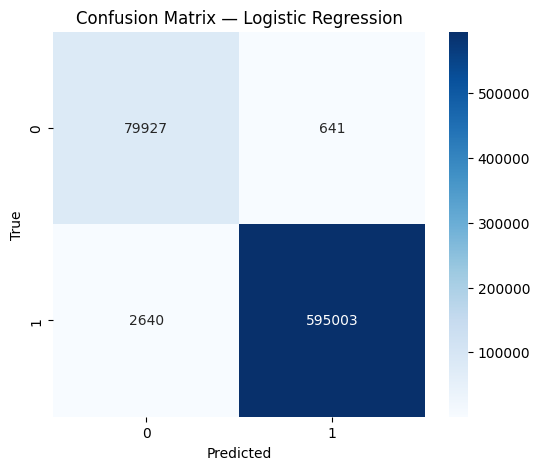

In [ ]:
cm = confusion_matrix(y_test, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### ROC Curve plot.

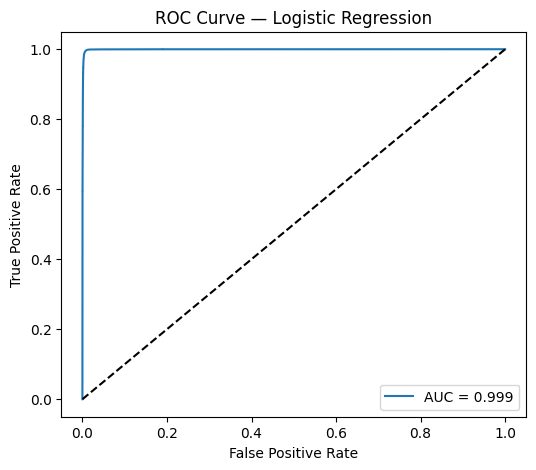

In [ ]:
fpr, tpr, _ = roc_curve(y_test, prob_scores)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.show()

#### Feature Importance "Coefficients".


Top 10 Positive Coefficients:
                 Feature  Coefficient
1        total_rec_prncp    26.369944
3              out_prncp    20.679439
2          out_prncp_inv    20.678116
0        last_pymnt_amnt     2.614954
23             sub_grade     0.937055
6    last_fico_range_low     0.884524
7   last_fico_range_high     0.883947
15   disbursement_method     0.614088
12                  term     0.326141
16      application_type     0.292119

Top 10 Negative Coefficients:
                 Feature  Coefficient
27         num_rev_accts    -0.058338
18                   dti    -0.082716
25             num_bc_tl    -0.113776
17              int_rate    -0.432053
14  debt_settlement_flag    -0.866243
5        total_pymnt_inv    -2.800157
4            total_pymnt    -4.320253
21             loan_amnt    -5.648933
19       funded_amnt_inv    -6.630097
20           funded_amnt    -7.178696


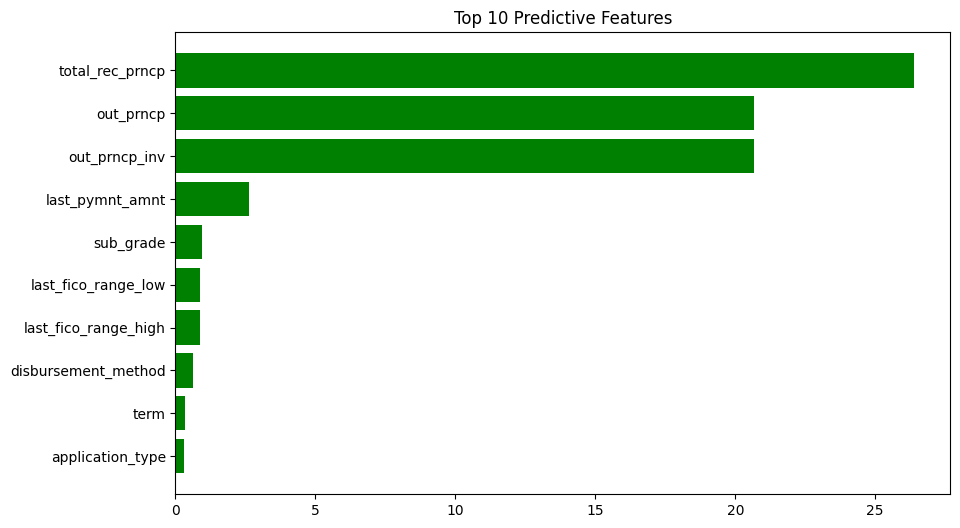

In [ ]:
coeff_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_clf.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("\nTop 10 Positive Coefficients:")
print(coeff_df.head(10))

print("\nTop 10 Negative Coefficients:")
print(coeff_df.tail(10))

plt.figure(figsize=(10,6))
plt.barh(coeff_df.head(10)["Feature"], coeff_df.head(10)["Coefficient"], color="green")
plt.title("Top 10 Predictive Features")
plt.gca().invert_yaxis()
plt.show()


#### Final Summary.

In [ ]:
print("\nSUMMARY")
print(f"Total Samples: {len(df)}")
print(f"Total Features: {X.shape[1]}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC Score: {auc_score:.4f}")


SUMMARY
Total Samples: 2260701
Total Features: 28
Accuracy: 0.9952
Precision: 0.9989
Recall: 0.9956
F1-score: 0.9973
AUC Score: 0.9994


In [ ]:
import pandas as pd

metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"],
    "Score": [accuracy, precision, recall, f1, auc_score]
})

print("\nModel Performance Summary")
display(metrics_df)


Model Performance Summary


,Metric,Score
0,Accuracy,0.995162
1,Precision,0.998924
2,Recall,0.995583
3,F1-Score,0.997250
4,AUC,0.999402


# K-Means

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score


In [ ]:
num_cols_for_kmeans = df_selected_corr.select_dtypes(include=[np.number]).columns
if 'loan_status' in num_cols_for_kmeans:
    num_cols_for_kmeans = num_cols_for_kmeans.drop('loan_status')

scaler_kmeans = StandardScaler()
df_selected_corr[num_cols_for_kmeans] = scaler_kmeans.fit_transform(df_selected_corr[num_cols_for_kmeans])

print("Standardization of K-Means features applied successfully. Ready for Clustering/PCA.")
X_kmeans = df_selected_corr.drop('loan_status', axis=1)

/tmp/ipython-input-3158396142.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_corr[num_cols_for_kmeans] = scaler_kmeans.fit_transform(df_selected_corr[num_cols_for_kmeans])


Standardization of K-Means features applied successfully. Ready for Clustering/PCA.


In [ ]:
wcss = []
k_values = range(1,11)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_kmeans)
    wcss.append(kmeans.inertia_)

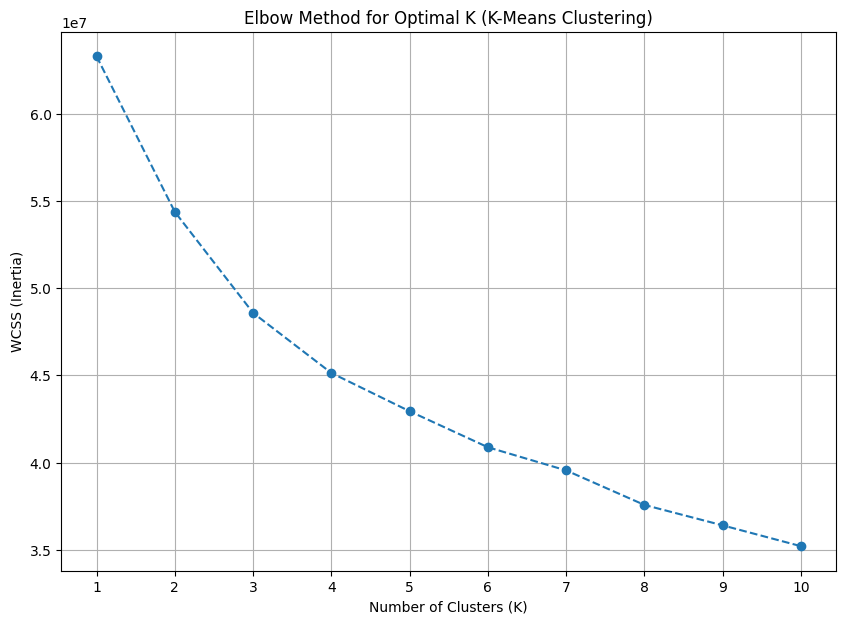

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (K-Means Clustering)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=5)
X_pca_for_kmeans = pca.fit_transform(X_kmeans)

In [ ]:
optimal_k =3

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_pca_for_kmeans)

df_with_clusters = df_selected_corr.copy()
df_with_clusters['Cluster'] = clusters


print("Cluster sizes:")
print(df_with_clusters['Cluster'].value_counts())

Cluster sizes:
Cluster
1    1209567
2     596247
0     454887
Name: count, dtype: int64


In [ ]:
sample_idx = np.random.choice(len(X_kmeans), size=int(0.05*len(X_kmeans)), replace=False)
sil_score = silhouette_score(X_kmeans.iloc[sample_idx], clusters[sample_idx])
print("Silhouette Score (sampled 5%):", sil_score)

Silhouette Score (sampled 5%): 0.15869363318211543


In [ ]:
cluster_analysis = df_with_clusters.drop('loan_status', axis=1).groupby('Cluster').mean()

print("\nCluster Profiling (Mean values of features per cluster):")
print(cluster_analysis.T)

print("\nDistribution of original target ('loan_status') across clusters:")
target_distribution = df_with_clusters.groupby('Cluster')['loan_status'].value_counts(normalize=True).unstack().fillna(0)
print(target_distribution)


Cluster Profiling (Mean values of features per cluster):
Cluster                      0         1         2
last_pymnt_amnt      -0.557971 -0.222224  0.876497
total_rec_prncp      -0.560319 -0.439619  1.319303
out_prncp_inv         1.720074 -0.410176 -0.480177
out_prncp             1.719984 -0.410149 -0.480163
total_pymnt          -0.461421 -0.489229  1.344494
total_pymnt_inv      -0.459860 -0.489779  1.344418
last_fico_range_low   0.319000 -0.205244  0.172996
last_fico_range_high  0.318998 -0.205244  0.172997
last_pymnt_d          0.295214 -0.033434 -0.157398
id                   -0.712742  0.087495  0.366268
url                  -0.712742  0.087495  0.366268
initial_list_status   0.482945 -0.126602 -0.111618
term                  0.551488 -0.389377  0.369165
last_credit_pull_d    0.279728 -0.023415 -0.165910
debt_settlement_flag -0.114052  0.044869 -0.004010
disbursement_method   0.513636 -0.111645 -0.165375
application_type      0.535762 -0.136947 -0.130926
int_rate              0.

In [ ]:
pca_plot = PCA(n_components=2)
X_pca_plot = pca_plot.fit_transform(X_kmeans)
df_with_clusters['PC1'] = X_pca_plot[:, 0]
df_with_clusters['PC2'] = X_pca_plot[:, 1]

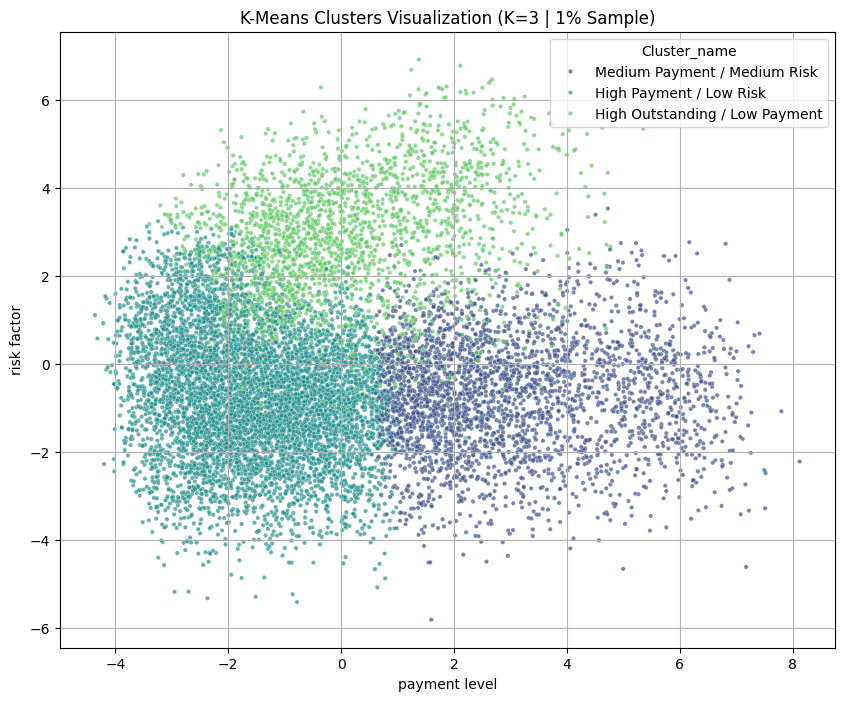

In [ ]:

df_with_clusters['PC1'] = df_with_clusters['PC1'] + np.random.normal(0, 0.02, len(df_with_clusters))
df_with_clusters['PC2'] = df_with_clusters['PC2'] + np.random.normal(0, 0.02, len(df_with_clusters))




df_sample_for_plot = df_with_clusters.sample(frac=0.005, random_state=42)


cluster_names = {0: 'High Outstanding / Low Payment',
                 1: 'High Payment / Low Risk',
                 2: 'Medium Payment / Medium Risk'}

df_sample_for_plot['Cluster_name'] = df_sample_for_plot['Cluster'].map(cluster_names)




plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster_name',
    data=df_sample_for_plot,
    palette='viridis',
    legend='full',
    alpha=0.7,
    s=10
)
plt.title(f'K-Means Clusters Visualization (K=3 | 1% Sample)')
plt.xlabel('payment level')
plt.ylabel(f'risk factor')
plt.grid(True)
plt.show()

